------------------------------------------------------------
# <center>**Arimedean Spiral Image Classification using keras and sklearn**</center>
------------------------------------------------------------

In [1]:
## -------------------------------------------------
#                  Import Libraries
## -------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization, used to plot total count for each label
import warnings
import os # used to iterate through all the images in the specified directory
import cv2

# libraries used for loading images and visualization
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data and generate augmented data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn import utils

# image conversion and processing library
import PIL
from PIL import Image
from scipy.interpolate import make_interp_spline

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow
import tensorflow as tf

# heatmap analysis libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model


## Create dataframe of image paths and associated labels

total number of labels:  102
total number of images:  102


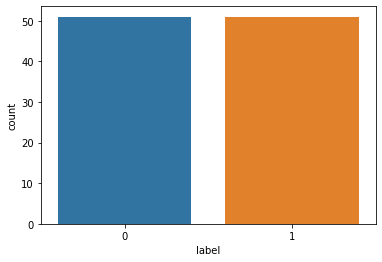

,images,label
84,Spiral_DataSet1_relabelled\healthy\V08HE01.png,0
83,Spiral_DataSet1_relabelled\parkinsons\V03PE02.png,1
36,Spiral_DataSet1_relabelled\parkinsons\V14PE03.png,1
13,Spiral_DataSet1_relabelled\parkinsons\V12PE03.png,1
4,Spiral_DataSet1_relabelled\healthy\V55HE08.png,0


In [2]:
## --------------------------------------------------------
#         Create a Dataframe of Images and Labels
## --------------------------------------------------------
# import all images and associated labels (healthy vs parkinsons)
dataset_folder = 'Spiral_DataSet1_relabelled' # name of folder containing images

img_path = [] # store image paths for all images (original image size: 256x256)
label = []    # healthy (0) vs parkinsons (1)

# iterate through all images and create a binary array corresponding to the image labels
for labeled_folder in os.listdir(dataset_folder):
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        if labeled_folder == 'healthy':
            label.append(0)
        else:
            label.append(1)
        img_path.append(os.path.join(dataset_folder, labeled_folder, img))

# total number of images and labels should match
print("total number of labels: ", len(label))
print("total number of images: ", len(img_path))

# create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label']  = label

df = df.sample(frac=1).reset_index(drop=True) # randomize images
df = utils.shuffle(df)

# show the total count for each of the labels
sns.countplot(df['label'])
plt.show()

df.head()

## Split into training, validation, and test data

In [3]:
## -----------------------------------------------------------
#     Split into training, validation, and testing data
## -----------------------------------------------------------
# randomly split data in train and validation subsets (70-30 split)
# stratify attempts to keep the labels 50-50 in the validation data (i.e. 7 total 0's and 8 total 1's)
train_feature, val_feature, train_label, val_label = train_test_split(df['images'], df['label'], test_size=0.30, stratify=df['label'])

# shuffle data
train_feature, train_label = utils.shuffle(train_feature, train_label)
val_feature, val_label = utils.shuffle(val_feature, val_label)

## (OPTIONAL) split validation data into validation and testing data
val_feature, test_feature, val_label, test_label = train_test_split(val_feature, val_label, test_size=0.5, shuffle=False)

print("total validation samples: ", len(val_label))
print("total testing samples: ", len(test_label))
print('total training samples: ', len(train_label))

total validation samples:  15
total testing samples:  16
total training samples:  71


## Perform data augmentation to artificially create more data

In [4]:
## ------------------------------------------
#       Convert images to raw pixels
## ------------------------------------------
# for each of the data sets (train, val, and test), convert from rgb to grayscale
# then convert to an array of pixels [0-255] --> this returns an array of size (256,256,1)
# resize to (128x128) for faster image processing and a more efficient model, data doesn't get lost in this resize
# need to account for the batch dimension (used in tensorflow), so expand dim to shape (1,128,128,1)
def img2array(dataset):
    storage_array = []
    for img_path in dataset:
        openImg = PIL.Image.open(img_path)
        image = openImg.convert("L") # covert to grayscale (L), color use (P)
        imgArray = np.array(image)
        imgArray = cv2.resize(imgArray, (128,128))
        imgArray = np.expand_dims(imgArray, axis=2) # if keeping rgb, use axis=0

        # store in array
        storage_array.append(imgArray)
    
    return storage_array

train_array = img2array(train_feature)
val_array   = img2array(val_feature)
test_array  = img2array(test_feature)

print('Train shape: ', np.shape(train_array[0]))
print('Validation shape: ', np.shape(val_array[0]))
print('Test shape: ', np.shape(test_array[0]))

Train shape:  (128, 128, 1)
Validation shape:  (128, 128, 1)
Test shape:  (128, 128, 1)


In [5]:
## -------------------------------------------------------------------
#       Artificially create more images for a bigger dataset
## -------------------------------------------------------------------
# define functions to generate batches of data containing augmented images
# use for training data only
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

# use for validation and testing data (OPTIONAL: can make this different than training)
test_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

## define function to artificially add more training, validation, and testing images
# takes as inputs the dataset array, dataset labels, and the number of additional augmented images per each original image
def generateAdditionalData(dataset_array, dataset_label, numImgs):
    dataAug = []
    dataAugLabel = []

    # iterate through each image in the data_array and create more images with the features specified by ImageDataGenerator
    for (idx,Lbl) in enumerate(dataset_label):
        tempImg = np.expand_dims(dataset_array[idx], axis=0) # use for grayscale
        # tempImg = train_array[idx]                         # use for rgb
        aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
        for addImages in range(numImgs):
            augImg = next(aug)[0] #.astype('uint8')
            if np.size(augImg) == 128**2:
                dataAug.append(augImg)
                dataAugLabel.append(Lbl)

    return dataAug, dataAugLabel

trainAug, trainAugLabel = generateAdditionalData(train_array, train_label, 90)
valAug, valAugLabel     = generateAdditionalData(val_array, val_label, 90)
testAug, testAugLabel   = generateAdditionalData(test_array, test_label, 90)

# covert label array to binary class matrix (healthy, PD)
trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
valAugLabel = tf.keras.utils.to_categorical(np.array(valAugLabel))
testAugLabel = tf.keras.utils.to_categorical(np.array(testAugLabel))

# shuffle data one last time
trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
valAug, valAugLabel = utils.shuffle(valAug, valAugLabel)
testAug, testAugLabel = utils.shuffle(testAug, testAugLabel)


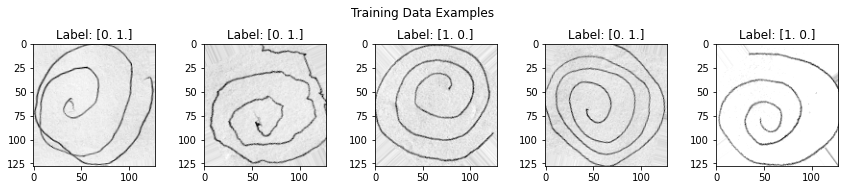

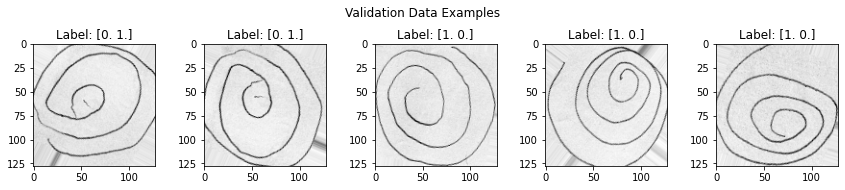

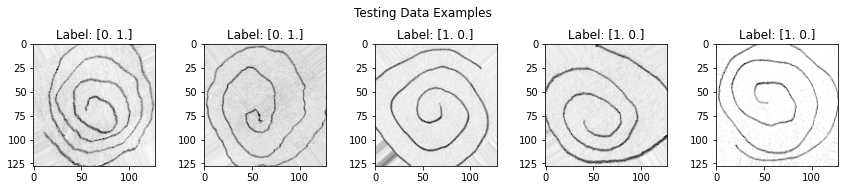

In [6]:
# show a few example images
def plotAugImgs(dataAug, dataAugLabel, dataTitle):
    count = 0 # counter to iterate through labels
    fig, axes = plt.subplots(1, 5, figsize=(12,2.5)) # create the figure window
    axes = axes.flatten()
    for img, ax in zip(dataAug, axes):
        ax.imshow(np.squeeze(img), cmap="gray") # plot image
        ax.set_title('Label: ' + str(dataAugLabel[count])) # display the associated label

        count = count + 1
        
    fig.suptitle(dataTitle)
    plt.tight_layout()
    plt.show()
    
plotAugImgs(trainAug, trainAugLabel, "Training Data Examples")
plotAugImgs(valAug, valAugLabel, "Validation Data Examples")
plotAugImgs(testAug, testAugLabel, "Testing Data Examples")

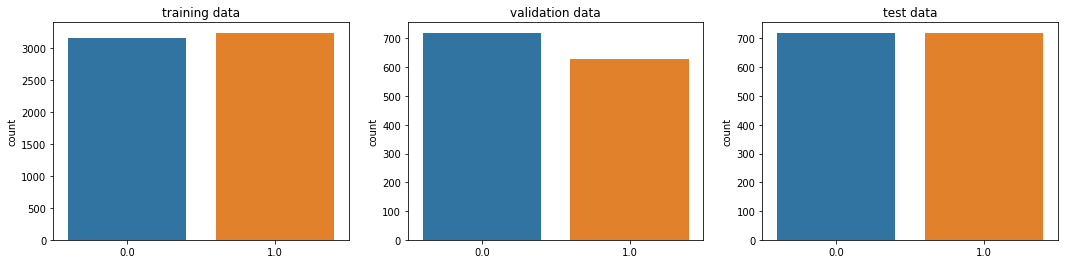

Total training data samples:  6390
Total validation data samples:  1350
Total test data samples:  1440
Training-to-validation ratio:  21.0 %


In [7]:
# Plot the total number of each label for each dataset
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,4)
ax0 = sns.countplot(trainAugLabel[:,1], ax=ax[0]); ax0.title.set_text("training data")
ax1 = sns.countplot(valAugLabel[:,1], ax=ax[1]); ax1.title.set_text("validation data")
ax2 = sns.countplot(testAugLabel[:,1], ax=ax[2]); ax2.title.set_text("test data")
plt.show()

print("Total training data samples: ", len(trainAug))
print("Total validation data samples: ", len(valAug))
print("Total test data samples: ", len(testAug))
print("Training-to-validation ratio: ", np.round(len(valAug)/len(trainAug),2)*100 , "%")

In [ ]:
# Can use to view original images in sepearte window 
imfile = Image.fromarray(np.squeeze(val_array[4]))
imfile.show(imfile)   

## Build a model

In [16]:
reg = tf.keras.regularizers.l2(0.001)               # include a regularizer to help prevent overfitting
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # use the Adam optimizer and set an effective learning rate 

# build a model
model = Sequential([
    Conv2D(32, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(128,128,1)),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(32, (3,3), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Conv2D(64, (5,5), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(128, (7,7), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Flatten(),

    ## include some fully connected layers
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2,activation='softmax') # softmax used for classification, sigmoid better for regression
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, batch_size=128, epochs=35, validation_data=(np.array(valAug), valAugLabel))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
## ------------------------------
##           Save the model
## ------------------------------
# save as both a tf file and h5
model.save('20220606_run2.h5')
model.save('20220606_run2.tf')

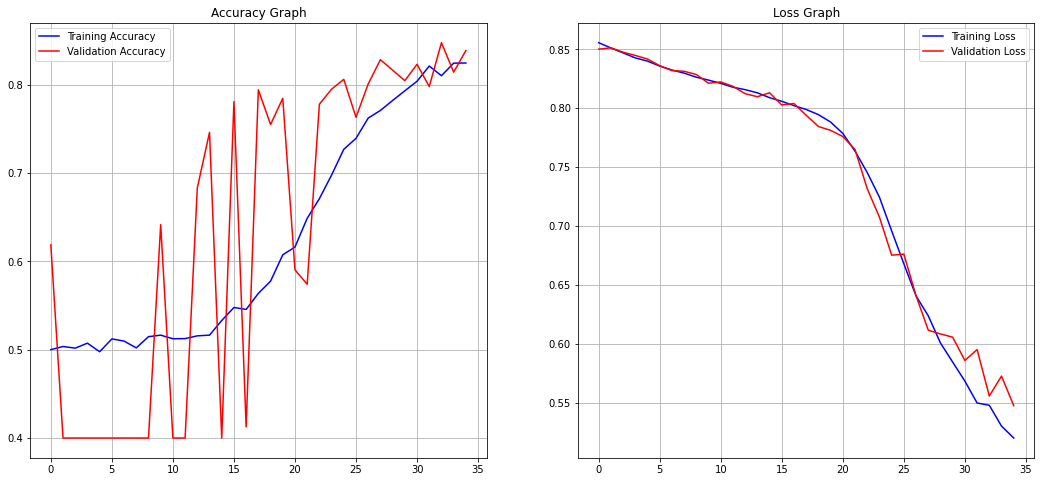

In [18]:
## -----------------------------------------------------------
#                       Plot the Results
## -----------------------------------------------------------
# Accuracy and Validation Accuracy
accuracy1 = trained_model.history['accuracy']
val_acc1 = trained_model.history['val_accuracy']
epochs = range(len(accuracy1))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax[0].plot(epochs, accuracy1, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'r', label='Validation Accuracy')
ax[0].title.set_text('Accuracy Graph')
ax[0].legend()
ax[0].grid()

# Loss and Validation Loss
loss1 = trained_model.history['loss']
val_loss1 = trained_model.history['val_loss']

ax[1].plot(epochs, loss1, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss1, 'r', label='Validation Loss')
ax[1].title.set_text('Loss Graph')
ax[1].legend()
ax[1].grid()

## Analysis of results and testing

In [19]:
loss, acc = model.evaluate(np.array(testAug), testAugLabel, verbose=2)

# classification report
pred = model.predict(np.array(testAug))
pred = np.argmax(pred, axis=1)
label_pred = np.argmax(testAugLabel, axis=1)
print(classification_report(label_pred, pred))

# confusion matrix
cmat = confusion_matrix(label_pred, pred)
print(cmat)

45/45 - 12s - loss: 0.6175 - accuracy: 0.6951 - 12s/epoch - 264ms/step
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       630
           1       0.68      0.86      0.76       810

    accuracy                           0.70      1440
   macro avg       0.70      0.67      0.67      1440
weighted avg       0.70      0.70      0.68      1440

[[305 325]
 [114 696]]


--------------------------------
## <center>**Load saved models to test**</center>

In [17]:
# load in model from saved h5 file
testModel = tf.keras.models.load_model('saved_h5_models/20220601_run2.h5')
testModel.summary()

# compute the prediction accuracy based on test data
loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 31, 31, 64)        204864    
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 27, 27, 64)     

In [115]:
## Define a function to plot the original test images (no augmentation applied) and associated labels
def plotImages(images_arr, label, rows, cols):
    count = 0
    fig, axes = plt.subplots(rows, cols, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.squeeze(img), cmap="gray") # plot image

        # use the model to predict the label
        predImg = testModel.predict(np.expand_dims(test_array[count], axis=0)) # use for grayscale
        # predImg = testModel.predict(test_array[count])                       # use for RGB
        predLabel = np.argmax(predImg[0])       
        
        if label[count] != predLabel:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color='red')
        else:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

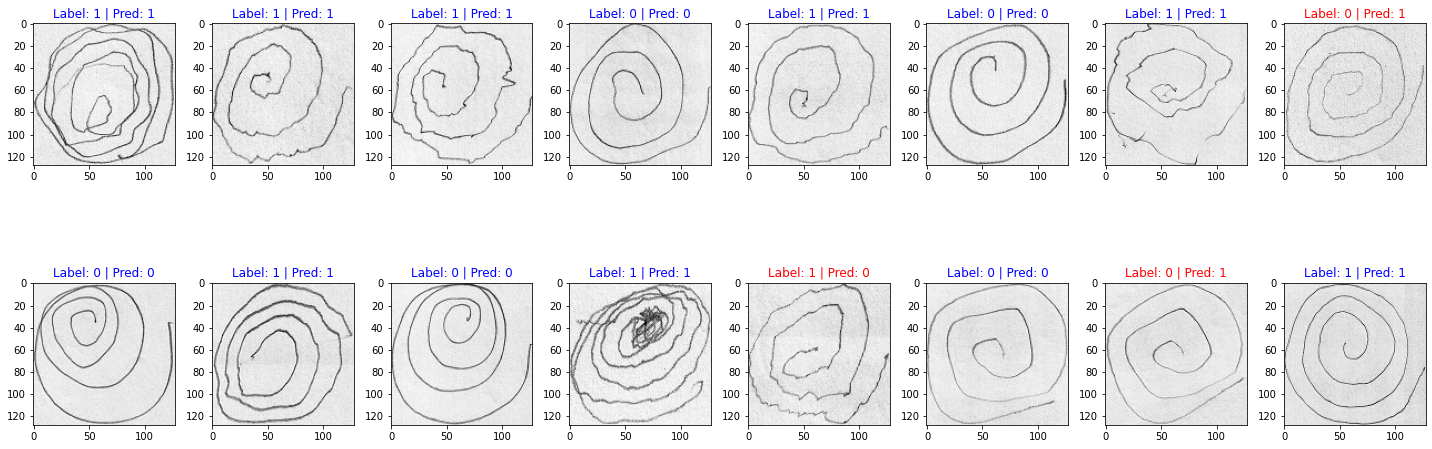

In [116]:
# Plot test_array images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotImages(test_array, test_label_array, rows, cols)

## Heatmap Grad-CAM

In [162]:
## plot the heatmap images
def plotHeatmapImages(images_arr, label, rows, cols):
    count = 0
    fig, axes = plt.subplots(rows, cols, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        #newImg=tf.image.rgb_to_hsv(img)

        ## ----------------------------------------------------------------------------------------------
        ##                                      OBTIAN HEATMAP IMAGE
        ## ----------------------------------------------------------------------------------------------
        testImg = np.expand_dims(test_array[count], axis=0) # use for grayscale
        # testImg = test_array[count] # use for RGB
        if np.size(testImg) != (128**2):
            testImg = np.reshape( np.zeros(128**2), (128,128,1)).astype(np.uint8)
            testImg = np.expand_dims(testImg, axis=0)
        testImg_pp = preprocess_input(testImg)

        with tf.GradientTape() as tape:
            last_conv_layer = testModel.get_layer('conv2')
            iterate = tf.keras.models.Model([testModel.inputs], [testModel.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(testImg_pp)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
        
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        reshape_size = np.sqrt(np.size(heatmap)).astype("uint8")
        heatmap = heatmap.reshape((reshape_size, reshape_size))
        # plt.matshow(heatmap)
        # plt.show()

        origImg = Image.fromarray(np.squeeze(testImg))
        rgbImg = origImg.convert("RGB")

        INTENSITY = .75
        heatmap = cv2.resize(heatmap, (128, 128))
        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

        heatImg = np.round((heatmap * INTENSITY + rgbImg) / (255*2) * 255).astype(np.uint8)
        # ----------------------------------------------------------------------------------------------
        # ----------------------------------------------------------------------------------------------

        ax.imshow(heatImg) 

        if np.size(test_array[count]) == (128**2):
            predImg = testModel.predict(np.expand_dims(test_array[count], axis=0)) # use for grayscale
            # predImg = testModel.predict(test_array[count]) # use for RGB
            predLabel = np.argmax(predImg[0])  
        else:
            predLabel = 'invalid image'     
        
        if label[count] != predLabel:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color='red')
        else:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

    # source code for generating heatmap: https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

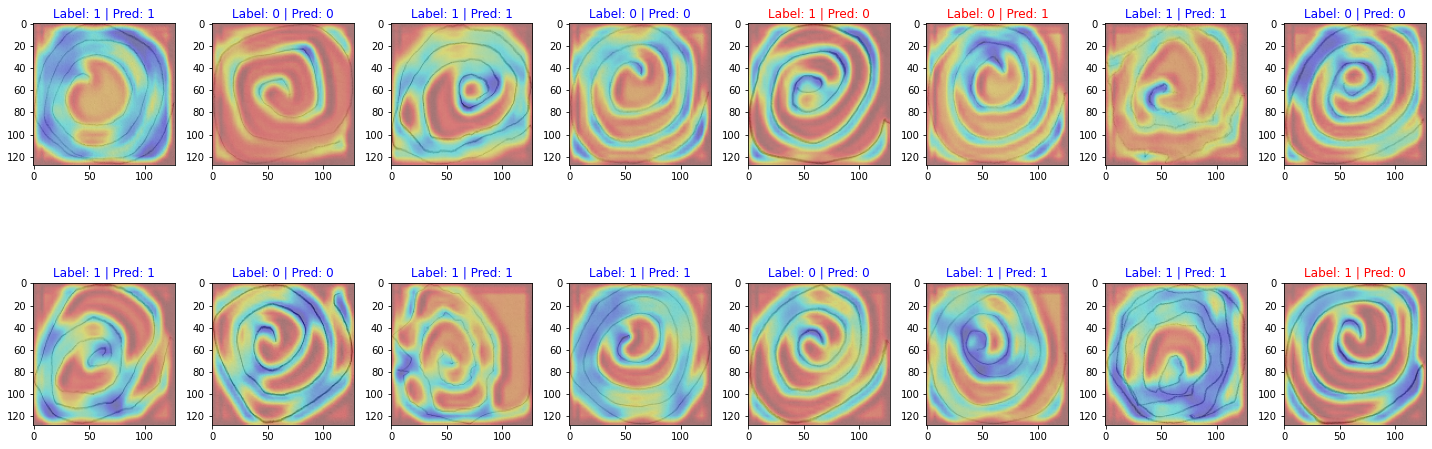

In [163]:
# Plot test_array heatmap images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotHeatmapImages(test_array, test_label_array, rows, cols)

--------------------
# <center>**Archimedean Spiral Model**</center>
--------------------

In [106]:
# can model the archimedean spiral via it's x and y components
# it is dependent on 'r', the length of the radius from the center and 't', time

# start by defining time and radius length as some arbitrary vector & number
t = np.linspace(0,6*np.pi,100) # controls the number of revolutions (best to use in as n*pi)
r = 1
imgSize = 25

# define the x and y components      
# x = r/ (2*np.pi) * (t**.75) * np.cos(t)
# y = r/ (2*np.pi) * (t**.75) * np.sin(t)

# generate non-ideal spiral
x = []
y = []
iter = 0
for i in t:
    x.append(r/ (2*np.pi) * (i**.75) * np.cos(i))
    y.append(r/ (2*np.pi) * (i**.75) * np.sin(i))

    if iter % 2 != 0: # if odd
        x[iter] = x[iter] #+ x[iter]/10
    else:
        y[iter] = y[iter] #+ y[iter]/10
    iter = iter + 1

x = np.array(x)
y = np.array(y)

# normalize
x = (x + np.abs(np.min(x)))/np.max(x)
y = (y + np.abs(np.min(y)))/np.max(y)

# convert to scale 128
x = x * (imgSize-1)
y = y * (imgSize-1)

# shift x or y centers as desired
# ytemp = y[0:500] + 10
# y[0:500] = ytemp

# save the figure and generate a
# plot of 2d line plot
plt.figure(figsize=(3,3))
plt.plot(x,y)
plt.axis('off')
plt.tight_layout
plt.savefig('testspiral', pad_inches=0, bbox_inches='tight')
plt.close()


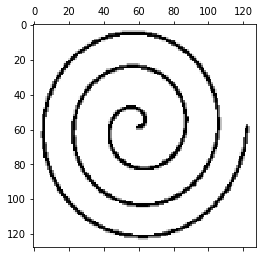

In [9]:
# open ideal spiral image and convert to an array of pixels
openImg = PIL.Image.open('testspiral.png')
arch_spiral = openImg.convert("L") # covert to grayscale (L), color use (P)
arch_spiral = np.array(arch_spiral)
arch_spiral = cv2.resize(arch_spiral, (128,128)) 

plt.matshow(arch_spiral, cmap='gray')


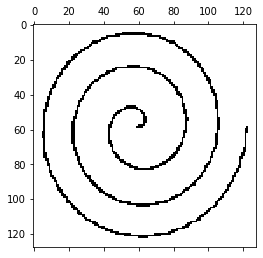

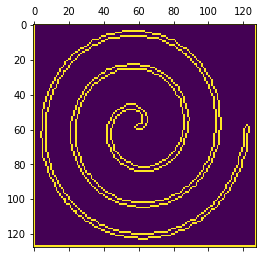

In [110]:
# find contours
thresh = 125

# get threshold image
ret, thresh_img = cv2.threshold(arch_spiral, thresh, 255, cv2.THRESH_BINARY)

plt.matshow(thresh_img, cmap='gray')

# find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# create empty image for contours
img_contours = np.zeros(arch_spiral.shape)
# draw the contours on the empty image
finalImg = cv2.drawContours(img_contours, contours, -1, (128,255,128), 1, cv2.LINE_AA)

plt.matshow(finalImg)

In [15]:
## Define a function to plot the original test images (no augmentation applied) and associated labels
def plotArchSpiralOverlay(images_arr, label, arch_spiral,rows, cols):
    count = 0
    fig, axes = plt.subplots(rows, cols, figsize=(20,6))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # overlay the simulated archimedean spiral with one of the original test images
        testImg = np.squeeze(test_array[count])
        testImg = cv2.adaptiveThreshold(testImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, 15)
        dispOverlay = arch_spiral/255 + testImg/255
        ax.imshow(dispOverlay*255, cmap="gray") # plot image 
        
        # use the model to predict the label
        predImg = testModel.predict(np.expand_dims(test_array[count], axis=0)) # use for grayscale
        # predImg = testModel.predict(test_array[count])                       # use for RGB
        predLabel = np.argmax(predImg[0])       
        
        if label[count] != predLabel:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color='red')
        else:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

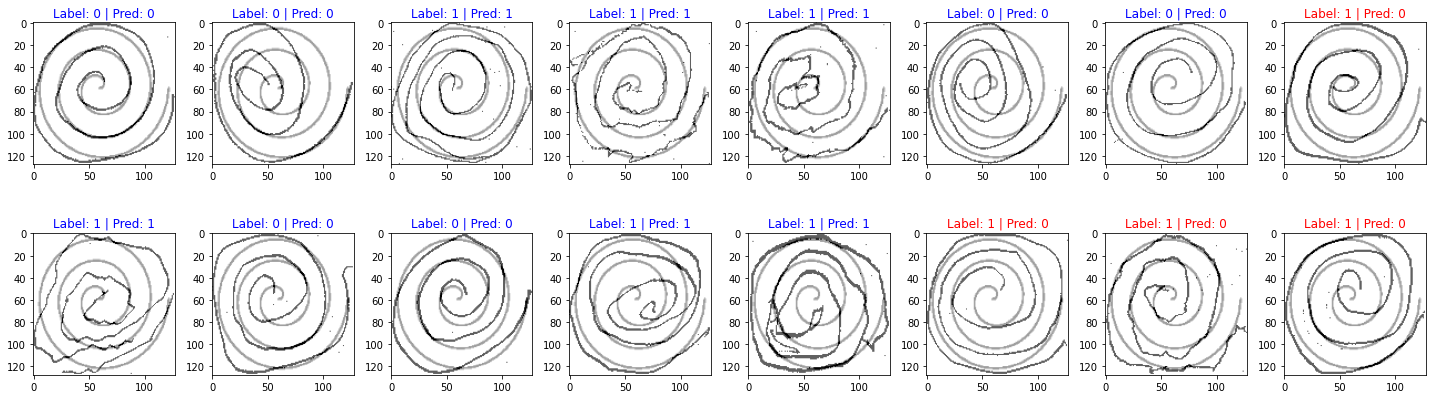

In [113]:
# Plot test_array heatmap images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotArchSpiralOverlay(test_array, test_label_array, arch_spiral, rows, cols)

## Calculate distance between spirals

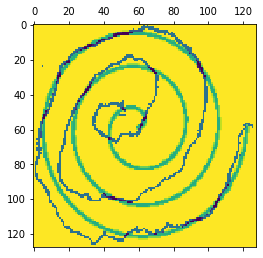

In [25]:
# overlay the ideal archimedean spiral and the test image
testImg = np.squeeze(test_array[0]) # convert to dim (128x128)
testImg = cv2.adaptiveThreshold(testImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, 15) # convert to binary array
dispOverlay = arch_spiral/255 + testImg/255 # overlay spirals | dispOverlay[row][col]

plt.matshow(dispOverlay)

In [10]:
# function to calculate the row and column errors
# takes a test images as input and whether or not iterating through row or column
def spiralErrorCalculation(overlaidSpirals, row_or_col):

    # iterate through each column and calculate the distance between the next closest "line" (i.e. pixels of the other spiral)
    rowVal = 2 # initialize the row value that will be iterated over

    rowDifferences = [] # store the row distance between arrays 
    iteratingRows  = True


    for col in range(len(overlaidSpirals)): # iterate over each column
        row           = 0    # define an iterator for loop over each row 
        prevRowVal    = 'none' # initialize the value of the previous row value
        currentRowVal = 'none' # initialize the value of the current row value

        # if col == 56:
        #     print('pause')
        while iteratingRows: # initialize rowVal to 2, so should immediately enter the while loop on first iteration
            # if row == 125:
            #     print('pause')
            rowVal = overlaidSpirals[row][col] # obtain the actual rowVal of the first pixel (top left)

            # if the row value is equal to a one, check the next row to see if also a one
            # if next row is a one, add the values of the two rows
            # then check the next row, if a one, add that value
            # once the next row is not a one, take the average row number 
            if rowVal == 1:
                currentRowVal = 'test spiral'
                numRows = 1
                nextNumIter = 1
                rowNum = row
                
                # account for the last row being out of bounds
                try:
                    nextRowVal = overlaidSpirals[row + nextNumIter][col]
                except: 
                    print("WARNING: on the last row")

                while rowVal == nextRowVal: # if the row after is is also equal to a one, enter this while loop
                    # then check how many rows have ones, once the nextRowVal is not equal to a one, break out of this loop
                    row = row + nextNumIter
                    rowNum = rowNum + row
                    numRows = numRows + 1

                    # account for the last row being out of bounds
                    try: 
                        nextRowVal = overlaidSpirals[row + nextNumIter][col]
                    except: 
                        print("WARNING: no more rows")
                        break

                # once the next number is not a one, average the row numbers that had consecutive values of one
                testRowAverage = (rowNum / numRows)

                # want to only calculate the distance between the spirals in the same rotation
                if prevRowVal == 'none':
                    prevRowVal = 'test spiral'
                
            # now do the same thing, but for row values not equal to 1 or 2
            if (rowVal != 1) & (rowVal != 2):
                currentRowVal = 'ideal spiral'
                numRows = 1
                nextNumIter = 1
                rowNum = row

                # account for the last row being out of bounds
                try:
                    nextRowVal = overlaidSpirals[row + nextNumIter][col]
                except: 
                    print("WARNING: on the last row")

                while (nextRowVal != 1) & (nextRowVal != 2): # if the row after is is also equal to a one, enter this while loop
                    # then check how many rows have ones, once the nextRowVal is not equal to a one, break out of this loop
                    row = row + nextNumIter
                    rowNum = rowNum + row
                    numRows = numRows + 1

                    # account for the last row being out of bounds
                    try: 
                        nextRowVal = overlaidSpirals[row + nextNumIter][col]
                    except: 
                        print("WARNING: no more rows")
                        break

                # once the next number is not a one, average the row numbers that had consecutive values of one
                idealRowAverage = (rowNum / numRows)

                # want to only calculate the distance between the spirals in the same rotation
                if prevRowVal == 'none':
                    prevRowVal = 'ideal spiral'
                
            # check to see if the prevRowVal was from the other spiral
            # if it is, calculate the difference between the two spirals
            if ((currentRowVal == 'ideal spiral') & (prevRowVal == 'test spiral')) | ((currentRowVal == 'test spiral') & (prevRowVal == 'ideal spiral')):
                rowDifferences.append(np.abs(idealRowAverage - testRowAverage))
                prevRowVal = 'none'
                currentRowVal = 'none'
                    
            if row == len(overlaidSpirals)-1: # once the last row has been reached, move to the next column
                break
            else:
                row = row + 1 # otherwise continue to the next row

    return rowDifferences, np.mean(rowDifferences), np.var(rowDifferences)

    

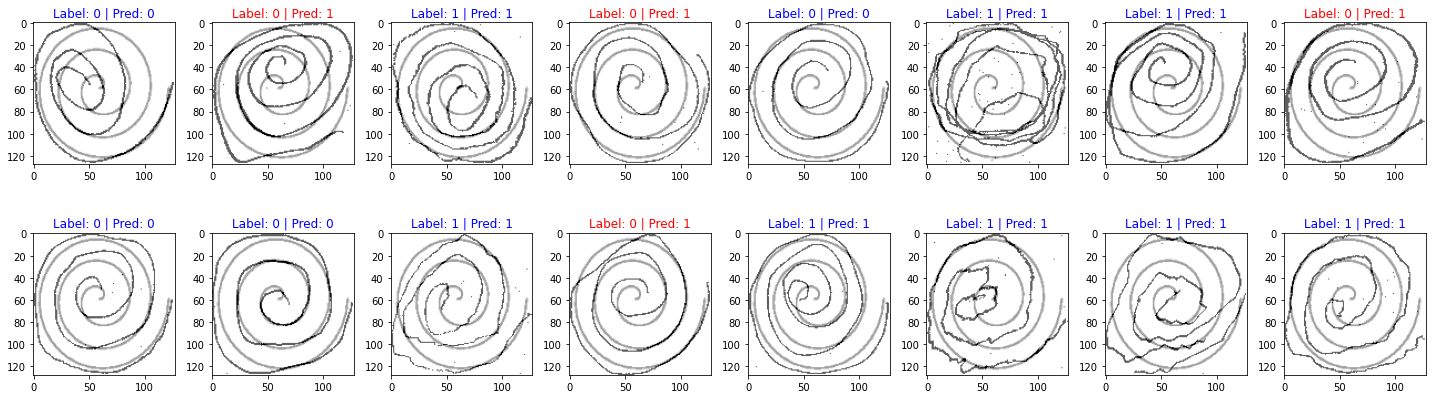

Labels: 
 [0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1]
Mean Row Error Distance: 
 [12.85, 10.31, 10.54, 8.4, 10.29, 10.72, 10.57, 11.79, 9.54, 9.01, 9.83, 8.45, 11.61, 12.16, 11.52, 11.55]
Variance Row Error: 
 [80.35, 65.49, 57.08, 45.03, 71.31, 83.55, 74.12, 75.09, 59.09, 50.08, 84.93, 30.67, 71.79, 95.36, 70.07, 105.64]


In [18]:
avgRowError = []
varRowError = []

# iterate through each test image overlapped with the ideal spiral
# calculate the mean and variance
for i in range(len(test_array)):
    # overlay the ideal archimedean spiral and the test image
    testImg = np.squeeze(test_array[i]) # convert to dim (128x128)
    testImg = cv2.adaptiveThreshold(testImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, 15) # convert to binary array
    dispOverlay = arch_spiral/255 + testImg/255 # overlay spirals | dispOverlay[row][col]

    # calculate the mean distance between the ideal and test images
    rowErrorVector, tempAvgRowError, tempVarRowError = spiralErrorCalculation(dispOverlay, 'col')
    # print("Mean Row Error Distance: ", round(avgRowError, 3))
    # print("Variance Row Error: ", round(varRowError, 3))

    avgRowError.append(np.round(tempAvgRowError,2))
    varRowError.append(np.round(tempVarRowError,2))

# Plot test_array overlaid images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotArchSpiralOverlay(test_array, test_label_array, arch_spiral, rows, cols)

print("Labels: \n", np.array(test_label))
print("Mean Row Error Distance: \n", avgRowError)
print("Variance Row Error: \n", varRowError)



--------------------------------------------------------------------------------------------------
# <center>**Archived Code**</center>
--------------------------------------------------------------------------------------------------

## Heatmap

I believe this only works for rgb images

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class idx used to measure the class, activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        # if the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attemp to find the final conv layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # else, grad-cam cannot be applied
        raise ValueError("Could not find 4d layer. Cannot apply Grad-CAM")

    def compute_heatmap(self, image, eps=1e-8):
        # construct gradient model by supplying
        #   (1) the inputs of the pre-trained model
        #   (2) the output of the final 4d layer 
        #   (3) the output of the softmax activations from the mdoel
        gradModel = Model(
            inputs  = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to float-32, pass the image through the grad model, and grab the loss associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predications) = gradModel(inputs)
            loss = predications[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the conv and guided gradients have a not needed batch dim, so discard it
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the avg of the grad values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dims of the input img and resize the output class actv. map to match the input img dims
        (w,h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w,h))

        # normalize the heatmap such that all values lie in the range [0,1], scale the results values in range [0,255], then convert to unsigned 8-bit int
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied colormap to the heatmap and then overlay the heatmap on the input img
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)
        output = np.round((1-alpha)*image + alpha*heatmap).astype(np.uint8)
        

        # return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

In [ ]:
# load the original img
orig = test_array[0]
# orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB)

# load the input image and preprocess it
image = test_array[0]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = imagenet_utils.preprocess_input(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=3)

# use the model to make predictions on the input image and find the class label idx with the largest corresponding probability
preds = testModel.predict(image)
i = np.argmax(preds[0])

print("Predicted Label: ", str(i))

# initialize the grad-CAM and build the heatmap
cam = GradCAM(testModel, i)
heatmap = cam.compute_heatmap(image)

# resize the resulting heatmap to the original input image dims and then overlay the heatmap on top of the image
heatmap = cv2.resize(heatmap, (128,128))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# display the orig image and resulting heatmap and output image
plt.matshow(output)

## Cat and Dog Heatmap Test

In [ ]:
# testImg = PIL.Image.open('C:/Users/Rebecca/Documents/Virginia_Tech/SP22/Research/cat_dog_classifier/kagglecatsanddogs_3367a/PetImages/Cat/1.jpg')
# testImg = np.array(testImg)
testImg = image.load_img('C:/Users/Rebecca/Documents/Virginia_Tech/SP22/Research/cat_dog_classifier/kagglecatsanddogs_3367a/PetImages/Cat/1.jpg', target_size=(128,128))
testImg = image.img_to_array(testImg)
testImg = np.expand_dims(testImg, axis=0)
testImg_pp = preprocess_input(testImg)

# testImgPred = testModel.predict(testImg_pp)

with tf.GradientTape() as tape:
  last_conv_layer = testModel.get_layer('conv2d_2')
  iterate = tf.keras.models.Model([testModel.inputs], [testModel.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(testImg_pp)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((12, 12))
# plt.matshow(heatmap)
# plt.show()

origImg = cv2.imread('C:/Users/Rebecca/Documents/Virginia_Tech/SP22/Research/cat_dog_classifier/kagglecatsanddogs_3367a/PetImages/Cat/1.jpg')
# rgbImg = origImg.convert("RGB")
# rgbImg = np.array(rgbImg)

INTENSITY = .5
heatmap = cv2.resize(heatmap, (300, 281))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
plt.matshow(heatmap)

# heatImg = np.round((heatmap * INTENSITY + rgbImg) / (255*2) * 255).astype(np.uint8)
heatImg = heatmap * INTENSITY + origImg
# heatImg = heatmap * INTENSITY + rgbImg
# print(heatImg[0])
# print(heatImg.astype(np.uint8)[0])

plt.matshow(heatImg/(255*2))
plt.show()

In [ ]:
# predict an original image
predImg = testModel.predict(np.expand_dims(test_array[1], axis=0))
predLabel = np.argmax(predImg[0])

if predLabel == 1:
    print("Predicted Label: Parkinson's Disease")
else:
    print("Predicted Label: Healthy")

if np.array(test_label)[1] == 1:
    print("Actual Label: Parkinson's Disease")
else:
    print("Actual Label: Healthy")

# imfile = Image.fromarray(np.squeeze(val_array[4]))
# imfile.show(imfile)  
# 
plt.imshow(test_array[1]) 

In [ ]:
## View heatmap for XAI
testImg = np.expand_dims(test_array[1], axis=0) # use for grayscale
testImg = test_array[6] # use for rgb
testImg_pp = preprocess_input(testImg)

testImgPred = testModel.predict(testImg)

with tf.GradientTape() as tape:
  last_conv_layer = testModel.get_layer('conv4')
  iterate = tf.keras.models.Model([testModel.inputs], [testModel.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(testImg_pp)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((4, 4))
# plt.matshow(heatmap)
# plt.show()

origImg = Image.fromarray(np.squeeze(testImg_pp))
rgbImg = origImg.convert("RGB")
rgbImg = np.array(rgbImg)

INTENSITY = .5
heatmap = cv2.resize(heatmap, (128, 128))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
plt.matshow(heatmap)

# heatImg = np.round((heatmap * INTENSITY + rgbImg) / (255*2) * 255).astype(np.uint8)
heatImg = heatmap * INTENSITY + rgbImg
# heatImg = heatmap * INTENSITY + rgbImg
# print(heatImg[0])
# print(heatImg.astype(np.uint8)[0])

plt.matshow(heatImg/(255*2))
plt.show()

# plt.imshow(heatImg)

In [ ]:
## ------------------------------------------
##              BEST MODEL
## ------------------------------------------
reg = tf.keras.regularizers.l2(0.001)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model = Sequential([
    Conv2D(128, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(256,256,3)),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(64, (5,5), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(64, (3,3), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(32, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((2,2), strides=(1,1)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    #Dense(32, activation='relu'),
    Dense(2,activation='softmax')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, batch_size=128, epochs=35, validation_data=(np.array(valAug), valAugLabel))

In [ ]:
# preallocate array and inset zeros where we want a pixel "visible"
arch_spiral = np.ones((imgSize,imgSize)) 

# round array values so they are int values from 0 to 128
xRounded = np.round(x).astype("int")
yRounded = np.round(y).astype("int")

for col in range(imgSize):
    xPos = np.where(xRounded == col)[0]
    if len(xPos) != 0:
        for k in range(len(xPos)):
            rowVal = yRounded[xPos[k]]
            arch_spiral[rowVal][col] = 0

print('pause')

arch_spiral = np.flip(arch_spiral, axis=0)
arch_spiral = cv2.resize(arch_spiral, (128, 128))
plt.figure(figsize=(5,5))
plt.matshow(arch_spiral, cmap="gray", fignum=1)